# 과제
## 201611523 안성빈

## 렌딩클럽에서 제공하는 개인별 신용 및 인구 통계학 데이터를 활용해 채무의 미래 상환 여부를 예측하는 모형 구축

# Library

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

import statsmodels.api as sm
from itertools import combinations
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve

from dmba import liftChart, gainsChart

# Data Description
- 관측치 개수:2000개 (상환 데이터 :1000개, 연체 데이터 1000개)
- 변수 개수 : 31개(출력변수 1개-y, 입력변수 30개 - v1~v30)

In [4]:
lc=pd.read_csv("lC_2000.csv")

In [5]:
lc

,y,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30
0,1.0,0.097436,0.097436,0.0,0.143302,0.082521,0.0,0.035197,0.000000,0.752688,...,0.109756,0.0,0.0,0.043499,0.092774,0.080551,0.277305,0.136022,0.259259,0.200000
1,1.0,0.402564,0.402564,0.0,0.526869,0.393844,0.0,0.025566,0.428571,0.026882,...,0.146341,0.0,0.0,0.246898,0.217133,0.144281,0.022116,0.174639,0.259259,0.240000
2,1.0,0.589744,0.589744,0.0,0.260125,0.520374,1.0,0.032483,0.000000,0.026882,...,0.207317,0.0,0.0,0.214719,0.171389,0.397614,0.029942,0.412517,0.259259,0.213333
3,1.0,0.282051,0.282051,1.0,0.493769,0.185826,1.0,0.033321,0.000000,0.107527,...,0.012195,0.0,0.0,0.020352,0.024386,0.037688,0.107179,0.017851,0.222222,0.093333
4,1.0,0.615385,0.615385,1.0,0.996106,0.537720,1.0,0.039010,0.000000,0.053763,...,0.085366,0.0,0.0,0.031486,0.031094,0.058306,0.020755,0.071519,0.148148,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.487179,0.487179,1.0,0.284657,0.285388,0.0,0.013881,0.000000,0.161290,...,0.243902,0.0,0.0,0.131431,0.117221,0.072485,0.120789,0.060209,0.111111,0.200000
1996,0.0,0.424359,0.424359,0.0,0.312305,0.382511,1.0,0.028753,0.000000,0.295699,...,0.000000,0.0,0.0,0.010512,0.023787,0.019466,0.066009,0.022470,0.333333,0.133333
1997,0.0,0.487179,0.487179,1.0,0.400312,0.306336,0.0,0.017634,0.000000,0.026882,...,0.109756,0.0,0.0,0.068838,0.063559,0.038322,0.013950,0.021449,0.185185,0.106667
1998,0.0,0.284615,0.284615,0.0,0.238707,0.249703,1.0,0.016902,0.000000,0.322581,...,0.012195,0.0,0.0,0.012647,0.022272,0.023420,0.050357,0.034258,0.185185,0.066667


In [6]:
# 결측치 확인
lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2000 non-null   float64
 1   v1      2000 non-null   float64
 2   v2      2000 non-null   float64
 3   v3      2000 non-null   float64
 4   v4      2000 non-null   float64
 5   v5      2000 non-null   float64
 6   v6      2000 non-null   float64
 7   v7      2000 non-null   float64
 8   v8      2000 non-null   float64
 9   v9      2000 non-null   float64
 10  v10     2000 non-null   float64
 11  v11     2000 non-null   float64
 12  v12     2000 non-null   float64
 13  v13     2000 non-null   float64
 14  v14     2000 non-null   float64
 15  v15     2000 non-null   float64
 16  v16     2000 non-null   float64
 17  v17     2000 non-null   float64
 18  v18     2000 non-null   float64
 19  v19     2000 non-null   float64
 20  v20     2000 non-null   float64
 21  v21     2000 non-null   float64
 22  

### 결측치는 없다

## 본격적으로 시작하기에 앞서 train과 validation set을 나누고 데이터 분석을 시작한다.


In [7]:
X=lc.drop(['y'],axis=1)
Y=lc["y"]

train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.2,random_state=1004)

# train데이터 
data=train_x.copy()
data['y']=train_y

# test데이터 
test_data=test_x.copy()
test_data['y']=test_y

In [8]:
test_data

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v22,v23,v24,v25,v26,v27,v28,v29,v30,y
1240,0.615385,0.615385,0.0,0.100467,0.510263,0.0,0.022662,0.000000,0.591398,0.026778,...,0.0,0.000000,0.146473,0.139144,0.063290,0.080980,0.076557,0.111111,0.146667,0.0
1676,0.358974,0.358974,0.0,0.150312,0.303734,1.0,0.019534,0.071429,0.053763,0.051486,...,0.0,0.000000,0.117109,0.101977,0.216862,0.042531,0.239705,0.296296,0.146667,0.0
627,0.358974,0.358333,1.0,0.863707,0.293032,1.0,0.028989,0.142857,0.026882,0.014697,...,0.0,0.000000,0.033313,0.028909,0.061688,0.012930,0.070730,0.111111,0.133333,1.0
877,0.239103,0.239103,0.0,0.242212,0.210267,0.0,0.017091,0.000000,0.430108,0.015362,...,0.0,0.000000,0.181459,0.168465,0.040516,0.013270,0.052334,0.148148,0.093333,1.0
1737,0.282051,0.282051,1.0,0.434190,0.179100,1.0,0.029496,0.000000,0.430108,0.007699,...,0.0,0.000000,0.020925,0.019597,0.038748,0.023137,0.043428,0.037037,0.040000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0.441667,0.441667,1.0,0.542445,0.301688,0.0,0.043247,0.285714,0.053763,0.058221,...,0.0,0.000000,0.069774,0.089486,0.061008,0.043552,0.051860,0.555556,0.240000,1.0
1069,0.102564,0.102564,0.0,0.198598,0.089105,1.0,0.008546,0.000000,0.215054,0.027624,...,0.0,0.000000,0.007921,0.012554,0.014668,0.023137,0.008504,0.185185,0.080000,0.0
1922,0.089744,0.089744,0.0,0.160826,0.076684,1.0,0.045124,0.000000,0.376344,0.076106,...,0.0,0.000000,0.024996,0.045514,0.046288,0.175230,0.039251,0.333333,0.213333,0.0
367,0.384615,0.383333,1.0,0.306464,0.227185,0.0,0.039624,0.000000,0.080645,0.022739,...,0.0,0.200716,0.178900,0.168094,0.053848,0.022457,0.065435,0.370370,0.266667,1.0


In [9]:
data

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v22,v23,v24,v25,v26,v27,v28,v29,v30,y
735,0.315385,0.315385,0.0,0.723131,0.332794,1.0,0.010009,0.214286,0.215054,0.030790,...,0.000000,0.002437,0.018738,0.026547,0.034699,0.061926,0.040950,0.222222,0.106667,1.0
443,0.410256,0.410256,1.0,0.628505,0.294248,0.0,0.003742,0.071429,0.188172,0.003887,...,0.000000,0.000000,0.014903,0.029810,0.001195,0.057843,0.000000,0.074074,0.106667,1.0
1483,0.189744,0.189744,0.0,0.318536,0.172482,1.0,0.013621,0.000000,0.080645,0.012476,...,0.000000,0.000000,0.004588,0.007129,0.008495,0.013950,0.011470,0.111111,0.053333,0.0
942,0.230769,0.230769,1.0,0.911604,0.193341,1.0,0.015238,0.000000,0.080645,0.015254,...,0.000000,0.000000,0.012725,0.013986,0.023564,0.008506,0.025887,0.111111,0.066667,1.0
355,0.302564,0.302564,1.0,0.236760,0.169614,0.0,0.028163,0.071429,0.349462,0.449266,...,0.000000,0.000000,0.086145,0.103057,0.159522,0.035046,0.053494,0.222222,0.160000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,0.445513,0.445513,0.0,0.532710,0.436419,0.0,0.022237,0.071429,0.026882,0.042328,...,0.333333,0.000000,0.046596,0.061580,0.031342,0.076557,0.026167,0.185185,0.186667,0.0
1349,0.358974,0.358974,1.0,0.172897,0.194123,1.0,0.010151,0.000000,0.268817,0.058302,...,0.000000,0.000000,0.013621,0.032424,0.025224,0.181014,0.015886,0.222222,0.106667,0.0
31,0.615385,0.615385,1.0,0.312305,0.368194,0.0,0.006338,0.000000,0.000000,0.088726,...,0.000000,0.006286,0.066416,0.106510,0.043291,0.075196,0.036940,0.185185,0.120000,1.0
523,0.692308,0.685897,0.0,0.211838,0.599429,0.0,0.023630,0.000000,0.672043,0.041814,...,0.000000,0.000000,0.083950,0.129774,0.068842,0.149030,0.111772,0.074074,0.080000,1.0


# EDA & Preprocessing

### 범주형 데이터 확인

In [10]:
data.v3.value_counts()# 1,0으로만 이루어져있다.

0.0    1092
1.0     508
Name: v3, dtype: int64

In [11]:
data.v6.value_counts() #1,0으로만 이루어져있다.

0.0    968
1.0    632
Name: v6, dtype: int64

## 각 변수와 y의 관계도를 그래프로 살펴본다

## boxplot

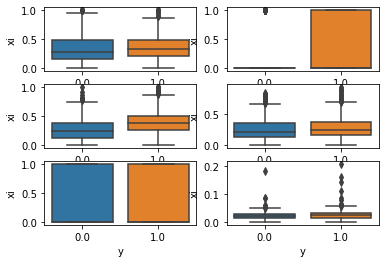

In [12]:
for i in range(6):
    data_v=pd.DataFrame({
        "xi":data.iloc[:,i+1],
        "y":data.y })
    plt.subplot(3,2,i+1)
    sns.boxplot(x="y", y="xi", data=data_v)     

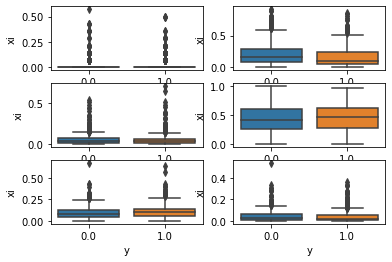

In [13]:
for i in range(6):
    data_v=pd.DataFrame({
        "xi":data.iloc[:,i+7],
        "y":data.y })
    plt.subplot(3,2,i+1)
    sns.boxplot(x="y", y="xi", data=data_v)  

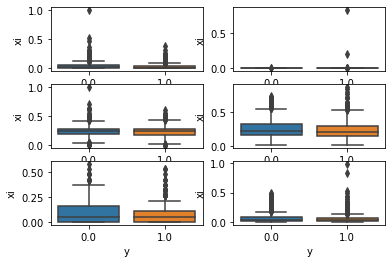

In [14]:
for i in range(6):
    data_v=pd.DataFrame({
        "xi":data.iloc[:,i+13],
        "y":data.y })
    plt.subplot(3,2,i+1)
    sns.boxplot(x="y", y="xi", data=data_v) 

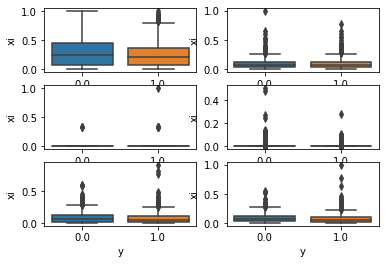

In [15]:
for i in range(6):
    data_v=pd.DataFrame({
        "xi":data.iloc[:,i+19],
        "y":data.y })
    plt.subplot(3,2,i+1)
    sns.boxplot(x="y", y="xi", data=data_v)

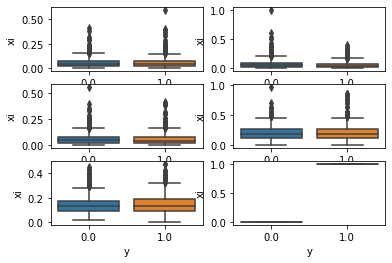

In [16]:
for i in range(6):
    data_v=pd.DataFrame({
        "xi":data.iloc[:,i+25],
        "y":data.y })
    plt.subplot(3,2,i+1)
    sns.boxplot(x="y", y="xi", data=data_v)

### 다음과 같은 변수가 y에 따라 큰 범주차이가 있어 보인다
- v3, v4, v5, v14, v15, v18, v19, v25


## 상관계수를 살펴본다

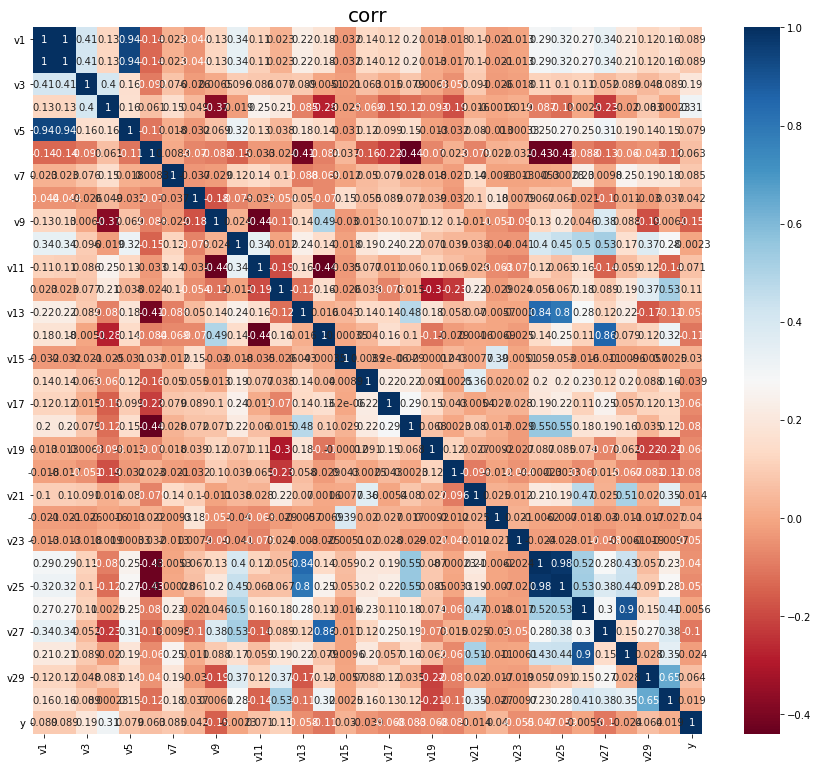

In [17]:
sns.heatmap(data=data.corr(),annot=True,cmap='RdBu')
fig=plt.gcf()
fig.set_size_inches(15,13)
plt.title('corr',fontsize=20)
plt.show()

### 복잡해보인 y와 변수들의 상관계수만 추출하여 본다

In [18]:
# 절대값으로 만들어주고 순서대로 나열한다
cor_y=pd.DataFrame(abs(data.corr().y).sort_values(ascending=False))
cor_y

,y
y,1.000000
v4,0.312497
v3,0.193599
v9,0.152259
v12,0.113309
v14,0.106033
v27,0.102622
v1,0.089224
v2,0.089108
v7,0.084705


## y와 변수간의 곡선 형태의 상관성이 있을 수 있다. 
## 그러므로 변수제곱을 해서 y와의 상관성을 살펴본다

In [19]:
data_sq=data**2

In [20]:
data_sq

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v22,v23,v24,v25,v26,v27,v28,v29,v30,y
735,0.099467,0.099467,0.0,0.522918,0.110752,1.0,0.000100,0.045918,0.046248,0.000948,...,0.000000,0.000006,0.000351,0.000705,0.001204,0.003835,0.001677,0.049383,0.011378,1.0
443,0.168310,0.168310,1.0,0.395018,0.086582,0.0,0.000014,0.005102,0.035409,0.000015,...,0.000000,0.000000,0.000222,0.000889,0.000001,0.003346,0.000000,0.005487,0.011378,1.0
1483,0.036003,0.036003,0.0,0.101465,0.029750,1.0,0.000186,0.000000,0.006504,0.000156,...,0.000000,0.000000,0.000021,0.000051,0.000072,0.000195,0.000132,0.012346,0.002844,0.0
942,0.053254,0.053254,1.0,0.831023,0.037381,1.0,0.000232,0.000000,0.006504,0.000233,...,0.000000,0.000000,0.000162,0.000196,0.000555,0.000072,0.000670,0.012346,0.004444,1.0
355,0.091545,0.091545,1.0,0.056055,0.028769,0.0,0.000793,0.005102,0.122124,0.201840,...,0.000000,0.000000,0.007421,0.010621,0.025447,0.001228,0.002862,0.049383,0.025600,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,0.198482,0.198482,0.0,0.283780,0.190462,0.0,0.000495,0.005102,0.000723,0.001792,...,0.111111,0.000000,0.002171,0.003792,0.000982,0.005861,0.000685,0.034294,0.034844,0.0
1349,0.128863,0.128863,1.0,0.029893,0.037684,1.0,0.000103,0.000000,0.072263,0.003399,...,0.000000,0.000000,0.000186,0.001051,0.000636,0.032766,0.000252,0.049383,0.011378,0.0
31,0.378698,0.378698,1.0,0.097535,0.135567,0.0,0.000040,0.000000,0.000000,0.007872,...,0.000000,0.000040,0.004411,0.011344,0.001874,0.005654,0.001365,0.034294,0.014400,1.0
523,0.479290,0.470455,0.0,0.044875,0.359315,0.0,0.000558,0.000000,0.451642,0.001748,...,0.000000,0.000000,0.007048,0.016841,0.004739,0.022210,0.012493,0.005487,0.006400,1.0


In [21]:
# y와의 제곱변수들의 상관성 추출
cor_y_sq=pd.DataFrame(abs(data_sq.corr().y).sort_values(ascending=False))
cor_y_sq

,y
y,1.000000
v4,0.263476
v3,0.193599
v9,0.140040
v12,0.085697
v27,0.083309
v20,0.078368
v11,0.070826
v18,0.069593
v1,0.068864


## 위의 2 y와의 상관관계 data를 결합하여 직선적 관계성은 없지만 곡선적 관계성이 있는 변수를 살펴본다

- quadratic 상관성-linear 상관성을 해서 직선성보다는 곡선성 상관관계가 큰 변수가 있는지 확인한다

In [22]:
cor_y['variable']=cor_y.index
cor_y_sq['variable']=cor_y_sq.index

# 데이터 결합
cor=pd.merge(cor_y,cor_y_sq,how="left",on=['variable'])

# 차이계산
cor['gap']=cor['y_y']-cor['y_x']
cor_r=cor.sort_values(by=['gap'], ascending=False)

cor_r


,y_x,variable,y_y,gap
27,0.019259,v30,0.030832,0.011574
29,0.005639,v26,0.013462,0.007823
30,0.002334,v10,0.008648,0.006314
24,0.038581,v16,0.041206,0.002625
16,0.063805,v29,0.064122,0.000317
17,0.062981,v6,0.062981,0.000000
0,1.000000,y,1.000000,0.000000
2,0.193599,v3,0.193599,0.000000
13,0.071010,v11,0.070826,-0.000183
11,0.080650,v20,0.078368,-0.002282


### 크게 직선성보다 곡선성 상관관계가 있는 변수는 보이지 않으므로 우선 변수를 그대로 사용한다

## 범주형 변수를 조금 더 자세히 살펴보기 위해 count table을 생성해본다

In [23]:
data_0=data[data['y']==0]
data_1=data[data['y']==1]

v3_count=pd.DataFrame(data_0.v3.value_counts())
v3_count.rename(columns = {'v3' : 'count_in_0'}, inplace = True)
v3_count['count_in_1']=data_1.v3.value_counts()

v3_count

,count_in_0,count_in_1
0.0,614,478
1.0,180,328


In [24]:
v6_count=pd.DataFrame(data_0.v6.value_counts())
v6_count.rename(columns = {'v6' : 'count_in_0'}, inplace = True)
v6_count['count_in_1']=data_1.v6.value_counts()

v6_count

,count_in_0,count_in_1
0.0,505,463
1.0,289,343


### v3의 경우 y 범주에 따라 count의 차이가 제법 보이고 v6는 덜해보인다.


## 조금 더 수치적으로 보기위해 분산 분석을 실시한다

In [25]:
v3_result=ols("v3~y",data=data).fit()
sm.stats.anova_lm(v3_result,type=2)

,df,sum_sq,mean_sq,F,PR(>F)
y,1.0,12.994954,12.994954,62.226549,5.631128e-15
Residual,1598.0,333.715046,0.208833,NaN,NaN


In [26]:
v6_result=ols("v6~y",data=data).fit()
sm.stats.anova_lm(v6_result,type=2)

,df,sum_sq,mean_sq,F,PR(>F)
y,1.0,1.516678,1.516678,6.363905,0.011743
Residual,1598.0,380.843322,0.238325,NaN,NaN


- anova의 p-value를 확인해본 결과, V3는 확실히 y와 관련성이 있다고 말할 수 있다. 
- v6같은 경우 역시 유의수준 0.05에서는 y와 관련성이 있다고 말할 수 있다. 하지만, 정규성 가정여부를 확인하지 않고 시행한 anova이기에 주어진 p-value로만 판단하기에는 섣부르다는 것을 고려하고 분석을 계속한다.

## 비모수적 집단별 평균차이 검정 Mann_Whitney U 검정을 통해 다른 변수들도 y범주의 따른 차이를 평균 차이를 비교한다. 


In [27]:
data_0_new=data_0.drop(['y','v3','v6'],axis=1)
data_1_new=data_1.drop(['y','v3','v6'],axis=1)

In [28]:
data_0_new

,v1,v2,v4,v5,v7,v8,v9,v10,v11,v12,...,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30
1483,0.189744,0.189744,0.318536,0.172482,0.013621,0.000000,0.080645,0.012476,0.481149,0.081633,...,0.012195,0.000000,0.000000,0.004588,0.007129,0.008495,0.013950,0.011470,0.111111,0.053333
1633,0.035897,0.035897,0.301791,0.033817,0.014872,0.000000,0.000000,0.000868,0.036804,0.102041,...,0.048780,0.000000,0.006812,0.011746,0.013174,0.021750,0.007826,0.028195,0.037037,0.080000
1666,0.358974,0.358974,0.571651,0.248792,0.018260,0.000000,0.080645,0.035426,0.589767,0.102041,...,0.000000,0.000000,0.000000,0.017073,0.018270,0.031616,0.027220,0.029986,0.222222,0.093333
1288,0.038462,0.038462,0.079439,0.031547,0.020974,0.000000,0.349462,0.068130,0.404847,0.040816,...,0.048780,0.000000,0.000000,0.020478,0.035156,0.037921,0.110582,0.040100,0.259259,0.146667
1383,0.128205,0.128205,0.179907,0.110236,0.020986,0.000000,0.053763,0.024347,0.285458,0.224490,...,0.024390,0.000000,0.040461,0.123529,0.117482,0.038931,0.060225,0.052409,0.259259,0.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.166667,0.166667,0.421729,0.158335,0.046340,0.000000,0.322581,0.034813,0.171454,0.142857,...,0.146341,0.000000,0.000962,0.016594,0.036203,0.030729,0.096632,0.032917,0.407407,0.253333
1971,0.179487,0.179487,0.291277,0.161427,0.021411,0.000000,0.080645,0.023419,0.494614,0.020408,...,0.280488,0.000000,0.002207,0.034398,0.030428,0.063697,0.014631,0.066100,0.148148,0.093333
1263,0.445513,0.445513,0.532710,0.436419,0.022237,0.071429,0.026882,0.042328,0.295332,0.081633,...,0.036585,0.333333,0.000000,0.046596,0.061580,0.031342,0.076557,0.026167,0.185185,0.186667
1349,0.358974,0.358974,0.172897,0.194123,0.010151,0.000000,0.268817,0.058302,0.263016,0.061224,...,0.073171,0.000000,0.000000,0.013621,0.032424,0.025224,0.181014,0.015886,0.222222,0.106667


In [29]:
# 각 변수를 y의 범주에 따라 Mannwhitneyu 검증을 하고 결과 p_vlaue를 확인한다.

p_mat=pd.DataFrame(np.zeros(shape=(28,2)))
p_mat.columns=['variable','p_value']
p_mat["variable"]=data_0_new.columns
p_mat.head()

,variable,p_value
0,v1,0.0
1,v2,0.0
2,v4,0.0
3,v5,0.0
4,v7,0.0


In [30]:
for i in range(28):
    v_0=y=data_0_new.iloc[:,i]
    v_1=y=data_1_new.iloc[:,i]
    
    p_mat.iloc[i,1]=round(mannwhitneyu(v_0,v_1).pvalue,6)

In [31]:
p_mat.head()

,variable,p_value
0,v1,0.000022
1,v2,0.000023
2,v4,0.000000
3,v5,0.000033
4,v7,0.000139


### p-value가 작은 순으로 변수를 나열하고 유의수준 0.05수준에서 H0(y범주에 따라 평균차이 x)기각할 수 있는지도 확인한다.

In [32]:
p_mat=p_mat.sort_values(by=['p_value'], ascending=True)
p_mat['reject_H0']=p_mat['p_value']<=0.01
p_mat

,variable,p_value,reject_H0
2,v4,0.000000,True
6,v9,0.000000,True
9,v12,0.000001,True
0,v1,0.000022,True
1,v2,0.000023,True
3,v5,0.000033,True
11,v14,0.000070,True
4,v7,0.000139,True
22,v25,0.000172,True
10,v13,0.000256,True


### 앞서 분석한 cor_y와 MannwhitneyU검증의 결과를 결합한 데이터를 생성하여 선택할 변수를 고려해보고자 한다.

In [33]:
cor_p=pd.merge(p_mat,cor_y,how="right",on=['variable'])
cor_p

,variable,p_value,reject_H0,y
0,y,NaN,NaN,1.000000
1,v4,0.000000,True,0.312497
2,v3,NaN,NaN,0.193599
3,v9,0.000000,True,0.152259
4,v12,0.000001,True,0.113309
5,v14,0.000070,True,0.106033
6,v27,0.000683,True,0.102622
7,v1,0.000022,True,0.089224
8,v2,0.000023,True,0.089108
9,v7,0.000139,True,0.084705


- 위의 표만으로는 변수 10개를 뽑기에는 부족하다고 생각한다. 
### 상관계수와 검증 면 둘 다 좋은 가치를 보여주는 변수들은 우선 선택하고 나머지 변수들은 CV를 통해서 추출해본다

### 우선 추출 변수:
- V4, V3, V9, V12, V14

### 나머지 변수는 의미있어 보이는 10개의 변수 중 5개를 추출하여 사용하기로 한다.
- 27,1,2,7,18,20,5,11,19,17 중에서 나머지 5개를 추출한다.

In [34]:
train_selected_x=train_x[["v3","v4","v9","v12","v14"]]
train_selected_x

,v3,v4,v9,v12,v14
735,0.0,0.723131,0.215054,0.122449,0.035355
443,1.0,0.628505,0.188172,0.020408,0.058659
1483,0.0,0.318536,0.080645,0.081633,0.005818
942,1.0,0.911604,0.080645,0.061224,0.000778
355,1.0,0.236760,0.349462,0.102041,0.013809
...,...,...,...,...,...
1263,0.0,0.532710,0.026882,0.081633,0.038708
1349,1.0,0.172897,0.268817,0.061224,0.128295
31,1.0,0.312305,0.000000,0.061224,0.003731
523,0.0,0.211838,0.672043,0.000000,0.111458


In [35]:
train_sub=train_x[['v27','v1','v2','v7','v18','v20','v5','v11','v19','v17']]
train_sub

,v27,v1,v2,v7,v18,v20,v5,v11,v19,v17
735,0.061926,0.315385,0.315385,0.010009,0.000000,0.166667,0.332794,0.326750,0.010610,0.185449
443,0.057843,0.410256,0.410256,0.003742,0.210526,0.750000,0.294248,0.039497,0.148541,0.291013
1483,0.013950,0.189744,0.189744,0.013621,0.000000,0.375000,0.172482,0.481149,0.023873,0.195435
942,0.008506,0.230769,0.230769,0.015238,0.000000,0.625000,0.193341,0.407540,0.148541,0.078459
355,0.035046,0.302564,0.302564,0.028163,0.157895,0.000000,0.169614,0.454219,0.018568,0.215407
...,...,...,...,...,...,...,...,...,...,...
1263,0.076557,0.445513,0.445513,0.022237,0.052632,0.458333,0.436419,0.295332,0.029178,0.447932
1349,0.181014,0.358974,0.358974,0.010151,0.000000,0.083333,0.194123,0.263016,0.013263,0.286733
31,0.075196,0.615385,0.615385,0.006338,0.157895,0.166667,0.368194,0.789946,0.037135,0.186876
523,0.149030,0.692308,0.685897,0.023630,0.157895,0.083333,0.599429,0.207361,0.429708,0.810271


In [36]:
s=[0,1,2,3,4,5,6,7,8,9]
combi=combinations(s,5)
# 위의 train_sub에서 5개를 추출하는 경우의 수를 뽑는다.
cc=list(combi)    
# 252개의 경우의 수를 생성했다.
len(cc)

252

## 252개의 가능한 Data set을 만들고 Cross_Validation결과를 통해 최적의 변수 조합을 추출한다.

In [37]:
ss=train_sub.iloc[:,list(cc[251])]

In [38]:
pd.concat([train_selected_x,ss],axis=1)

,v3,v4,v9,v12,v14,v20,v5,v11,v19,v17
735,0.0,0.723131,0.215054,0.122449,0.035355,0.166667,0.332794,0.326750,0.010610,0.185449
443,1.0,0.628505,0.188172,0.020408,0.058659,0.750000,0.294248,0.039497,0.148541,0.291013
1483,0.0,0.318536,0.080645,0.081633,0.005818,0.375000,0.172482,0.481149,0.023873,0.195435
942,1.0,0.911604,0.080645,0.061224,0.000778,0.625000,0.193341,0.407540,0.148541,0.078459
355,1.0,0.236760,0.349462,0.102041,0.013809,0.000000,0.169614,0.454219,0.018568,0.215407
...,...,...,...,...,...,...,...,...,...,...
1263,0.0,0.532710,0.026882,0.081633,0.038708,0.458333,0.436419,0.295332,0.029178,0.447932
1349,1.0,0.172897,0.268817,0.061224,0.128295,0.083333,0.194123,0.263016,0.013263,0.286733
31,1.0,0.312305,0.000000,0.061224,0.003731,0.166667,0.368194,0.789946,0.037135,0.186876
523,0.0,0.211838,0.672043,0.000000,0.111458,0.083333,0.599429,0.207361,0.429708,0.810271


In [39]:
# cv 결과를 받아줄 행렬 생성
cv_mat=pd.DataFrame(np.zeros(shape=(252,3)))
cv_mat.columns=['variable_case','accuracy_mean','accuracy_variance']
cv_mat['variable_case']=list(range(252))
cv_mat

,variable_case,accuracy_mean,accuracy_variance
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
247,247,0.0,0.0
248,248,0.0,0.0
249,249,0.0,0.0
250,250,0.0,0.0


In [40]:
model = LogisticRegression()

# logistic model을 252가지의 경우로 Cross_validation 하여
# accuracy의 평균 및 분산을 추출
for i in range(252):
    ss=train_sub.iloc[:,list(cc[i])]
    train_new_x=pd.concat([train_selected_x,ss],axis=1)
    
    cross_score_logit=cross_val_score(model,train_new_x,train_y,scoring="accuracy",cv=5)
    
    cv_mat.iloc[i,1]=cross_score_logit.mean()
    cv_mat.iloc[i,2]=cross_score_logit.var()
    

In [41]:
cv_mat

,variable_case,accuracy_mean,accuracy_variance
0,0,0.638125,0.001185
1,1,0.643125,0.000373
2,2,0.642500,0.000479
3,3,0.638125,0.000740
4,4,0.640625,0.000652
...,...,...,...
247,247,0.640625,0.000980
248,248,0.640625,0.001219
249,249,0.631875,0.000888
250,250,0.638125,0.000920


In [42]:
cv_mat_new=cv_mat.sort_values(by=['accuracy_mean'], ascending=False)
cv_mat_new.head(30)

,variable_case,accuracy_mean,accuracy_variance
174,174,0.643125,0.000463
209,209,0.643125,0.000463
135,135,0.643125,0.000486
1,1,0.643125,0.000373
64,64,0.642500,0.000827
154,154,0.642500,0.000389
206,206,0.642500,0.000397
96,96,0.642500,0.001084
171,171,0.642500,0.000397
2,2,0.642500,0.000479


### 가장 정확도가 높고 CV내에서의 variance가 낮았던 variable_case1을 선택한다.

In [43]:
ss_1=train_sub.iloc[:,list(cc[1])]
train_new_x_1=pd.concat([train_selected_x,ss_1],axis=1)
train_new_x_1

,v3,v4,v9,v12,v14,v27,v1,v2,v7,v20
735,0.0,0.723131,0.215054,0.122449,0.035355,0.061926,0.315385,0.315385,0.010009,0.166667
443,1.0,0.628505,0.188172,0.020408,0.058659,0.057843,0.410256,0.410256,0.003742,0.750000
1483,0.0,0.318536,0.080645,0.081633,0.005818,0.013950,0.189744,0.189744,0.013621,0.375000
942,1.0,0.911604,0.080645,0.061224,0.000778,0.008506,0.230769,0.230769,0.015238,0.625000
355,1.0,0.236760,0.349462,0.102041,0.013809,0.035046,0.302564,0.302564,0.028163,0.000000
...,...,...,...,...,...,...,...,...,...,...
1263,0.0,0.532710,0.026882,0.081633,0.038708,0.076557,0.445513,0.445513,0.022237,0.458333
1349,1.0,0.172897,0.268817,0.061224,0.128295,0.181014,0.358974,0.358974,0.010151,0.083333
31,1.0,0.312305,0.000000,0.061224,0.003731,0.075196,0.615385,0.615385,0.006338,0.166667
523,0.0,0.211838,0.672043,0.000000,0.111458,0.149030,0.692308,0.685897,0.023630,0.083333


In [57]:
train_new_x_1.columns

Index(['v3', 'v4', 'v9', 'v12', 'v14', 'v27', 'v1', 'v2', 'v7', 'v20'], dtype='object')

### 추가된 변수들을 살펴보니, 상관관계와 p-value를 고려했던 순서와 비슷함을 알 수 있다. 

# 예측
### 위에서 선택된 변수 v2,3,9,12,14,27,1,2,7,20을 이용해서 test_set을 예측하고 평가한다.

## 모델학습

In [44]:
model = LogisticRegression()
model.fit(train_new_x_1,train_y)

LogisticRegression()

### test역시 최종 변수 추출한 데이터 생성


In [45]:
test_new_x=test_x[train_new_x_1.columns]
test_new_x

,v3,v4,v9,v12,v14,v27,v1,v2,v7,v20
1240,0.0,0.100467,0.591398,0.061224,0.062686,0.080980,0.615385,0.615385,0.022662,0.333333
1676,0.0,0.150312,0.053763,0.102041,0.005446,0.042531,0.358974,0.358974,0.019534,0.375000
627,1.0,0.863707,0.026882,0.081633,0.002312,0.012930,0.358974,0.358333,0.028989,0.083333
877,0.0,0.242212,0.430108,0.040816,0.005122,0.013270,0.239103,0.239103,0.017091,0.208333
1737,1.0,0.434190,0.430108,0.122449,0.016765,0.023137,0.282051,0.282051,0.029496,0.125000
...,...,...,...,...,...,...,...,...,...,...
384,1.0,0.542445,0.053763,0.122449,0.003543,0.043552,0.441667,0.441667,0.043247,0.583333
1069,0.0,0.198598,0.215054,0.081633,0.010207,0.023137,0.102564,0.102564,0.008546,0.208333
1922,0.0,0.160826,0.376344,0.061224,0.106063,0.175230,0.089744,0.089744,0.045124,0.625000
367,1.0,0.306464,0.080645,0.204082,0.012441,0.022457,0.384615,0.383333,0.039624,0.125000


### 예측

In [46]:
y_hat=model.predict(test_new_x)

### 정오행렬표 생성

In [47]:
pd.DataFrame(confusion_matrix(test_y,y_hat))

,0,1
0,139,67
1,64,130


### 정확도 계산하기

In [48]:
accuracy_score(test_y,y_hat)

0.6725

### 민감도, 특이도 등 종합적 계산하기

In [49]:
target_names = ['class 0', 'class 1']
print(classification_report(test_y, y_hat, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.68      0.67      0.68       206
     class 1       0.66      0.67      0.66       194

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



### ROC curve그리기

In [50]:
# roc_curve 생성하는 함수 생성
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [51]:
# 예측 값이 아닌 예측 확률 추출 (1에 대해서)
prob=model.predict_proba(test_new_x)[:,1]

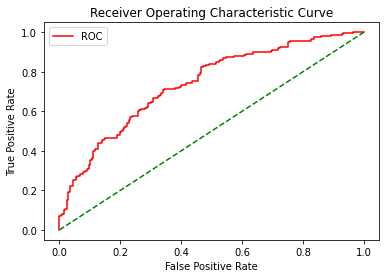

In [52]:
fper, tper, thresholds = roc_curve(test_y, prob)
plot_roc_curve(fper, tper)


### gain chart&lift chart

In [53]:
df_for_lift=pd.DataFrame({'prob':prob,'real':test_y})

df_for_lift=df_for_lift.sort_values(by=['prob'],ascending=False)

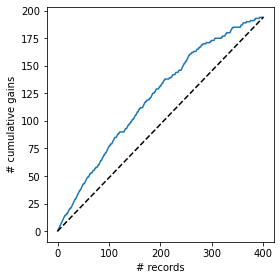

In [54]:
gainsChart(df_for_lift.real,figsize=(4,4))

plt.tight_layout()
plt.show()

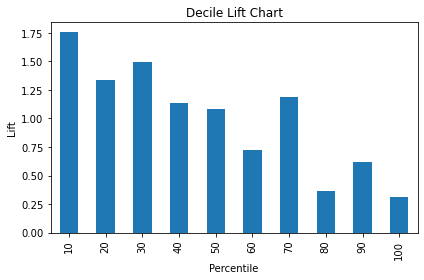

In [55]:
liftChart(df_for_lift.real,labelBars=False)
plt.tight_layout()
plt.show()

# test에 대한 최종 accuracy=0.6725

In [56]:
accuracy_score(test_y,y_hat)

0.6725